<a href="https://colab.research.google.com/github/GeorgeThan414/Machine_Learning_CSD/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Task - 1

# Load the dataset , Split the dataset to train/test, visualize the features with barplots


In [ ]:
df= pd.read_csv("train.csv")

# Create X, y : y= target
X = df.drop(columns=['target'])
y = df['target']

#Split the dataset
seed=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (6851, 4)
X_test shape: (762, 4)


# Is dataset balanced?

The dataset is not balanced, due to the difference in total samples between the two classes. The class with target "0" has more samples than the other class.

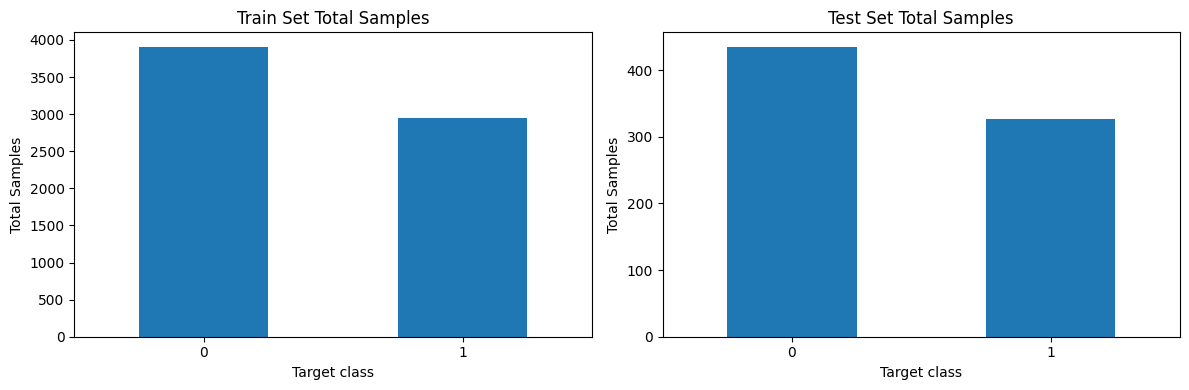

In [ ]:
# Total Train & Test counts for the target features
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
train_counts.plot(kind="bar", ax=axes[0])
axes[0].set_title("Train Set Total Samples")
axes[0].set_xlabel("Target class")
axes[0].set_ylabel("Total Samples")
axes[0].tick_params(axis="x", rotation=0)

# Test
test_counts.plot(kind="bar", ax=axes[1])
axes[1].set_title("Test Set Total Samples")
axes[1].set_xlabel("Target class")
axes[1].set_ylabel("Total Samples")
axes[1].tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()


# Task - 2


#Drop the features "id", "location", replaces teh nan with null, merge  keyword and text

In [ ]:
# Drop the two features
X_train = X_train.drop(columns=["id", "location"])
X_test  = X_test.drop(columns=["id", "location"])

# Replace NaN with null
X_train = X_train.fillna("null")
X_test  = X_test.fillna("null")

# Merge keyword with text
X_train["inputs"] = X_train["keyword"] + " " + X_train["text"]
X_test["inputs"]  = X_test["keyword"] + " " + X_test["text"]

# Task - 3

For this task,  the function techniques will be copied in order to remome any reduntant information from the current inputs feature.
Below, it appears the functions that will be applied to the train - test sets.

1) removeUnicode: removes unicode characters and emojis from the text.

2) replaceURL: removes URLS from the text.

3) replaceAtUser: removes user mentions (e.g., @username).

4) removeHashtagInFrontOfWord: removes the hashtag symbol while keeping the word itself.

5) replaceContraction: expands English contractions (e.g., “can't” → “cannot”).

6) removeNumbers: removes numeric characters from the text.

7) replaceElongated: normalizes elongated words (e.g., “soooo” → “soo”).

8) replaceMultiExclamationMark: replaces multiple exclamation marks with a single one.

9) replaceMultiQuestionMark: replaces multiple question marks with a single one.

10) replaceMultiStopMark: replaces multiple dots with a single dot.

11) removeEmoticons: removes textual emoticons from the text.

12) Stopword Removal: removes common English stopwords using NLTK.

13) Lemmatization: reduces words to their base (lemma) form using WordNet lemmatization.


In [ ]:
from techniques import (
    removeUnicode,
    replaceURL,
    replaceAtUser,
    removeHashtagInFrontOfWord,
    replaceContraction,
    removeNumbers,
    replaceElongated,
    replaceMultiExclamationMark,
    replaceMultiQuestionMark,
    replaceMultiStopMark,
    removeEmoticons,
    stopwords,
    WordNetLemmatizer)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()                  # reduces words to their base form
stop_words = set(stopwords.words('english'))      # common English words that carrry little semantic meaning.

def clean_text(text):
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = replaceContraction(text)
    text = removeNumbers(text)
    text = replaceElongated(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = removeEmoticons(text)

    # lowercase
    text = text.lower()

    # stopwords
    text = " ".join(w for w in text.split() if w not in stop_words)

    # lemmatization
    text = " ".join(lemmatizer.lemmatize(w) for w in text.split())

    return text

#Apply the above function to the X_train & X_test

In [ ]:
X_train["clean"] = X_train["inputs"].apply(clean_text)
X_test["clean"]  = X_test["inputs"].apply(clean_text)

# Task - 4  Convert them to numpy arrays

In [ ]:
X_train_inputs = X_train["clean"].to_numpy()
X_test_inputs  = X_test["clean"].to_numpy()

# Targets (labels)
y_train_targets = y_train.to_numpy()
y_test_targets  = y_test.to_numpy()

# Task -5 Tfidf Vectorized the matrices

In [ ]:
tfidf = TfidfVectorizer()
# Train set
X_train_tfidf = tfidf.fit_transform(X_train_inputs)
# Test set
X_test_tfidf = tfidf.transform(X_test_inputs)


# Task - 6 SVM

By defining the necessary parameters to the SVM, it can be achieved better results in the metrics, such as accuracy, recall, precision. The "class_weight" hyperparameter, makes the dataset balanced which is necessary to make final accuracy of the model realistic.

The most important metric is Recall, because it measures how many of the predicted disaster tweets are indeed correct. Otherwise, there will be misinformation in the web which will affect tremendous the mitigation and the elimination of new disasters like fires. In general, recall is the most important metric in datasets which are related to deseases or disasters, etc, because False Negative classified samples play crucial role.

The results from training to testing depicts significant change from 0.9 to 0.7, which may be caused from the overffiting in the train set.

In [ ]:
seed=0
#Fit the svm to the X_train
svm_clf = LinearSVC(C=1.0,class_weight="balanced", random_state=seed)
svm_clf.fit(X_train_tfidf, y_train_targets)

# Predictions
y_train_pred = svm_clf.predict(X_train_tfidf)
y_test_pred  = svm_clf.predict(X_test_tfidf)

In [ ]:
# Print the metrics
def evaluate(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name} Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\n")

evaluate(y_train_targets, y_train_pred, "Train")
evaluate(y_test_targets,  y_test_pred, "Test")

Train Metrics:
Accuracy : 0.9647
Precision: 0.9595
Recall   : 0.9582
F1-score : 0.9589


Test Metrics:
Accuracy : 0.8097
Precision: 0.7725
Recall   : 0.7890
F1-score : 0.7806




# Task - 7 PCA keeping the 95% of the variance  of the original dataset

In [ ]:
# Convert the TF-IDF to dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

seed=0
pca = PCA(n_components=0.95,  random_state=seed)

X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca  = pca.transform(X_test_dense)

# Print the total PCA dimensions and the maintained information

In [ ]:
print("Initial Dimensions:", X_train_dense.shape[1])
print("PCA Dimensions   :", X_train_pca.shape[1])
print("Maintained Information:", pca.explained_variance_ratio_.sum())

Initial Dimensions: 12533
PCA Dimensions   : 3708
Maintained Information: 0.9500319724665577


In [ ]:
seed=0
#Fit the svm to the X_train
svm_clf = LinearSVC(C=1.0, class_weight="balanced", random_state=seed)
svm_clf.fit(X_train_pca, y_train_targets)

# Predictions
y_train_pred_linear = svm_clf.predict(X_train_pca)
y_test_pred_linear  = svm_clf.predict(X_test_pca)

# Just SVM
rbf_svc_pca = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=seed)

rbf_svc_pca.fit(X_train_pca, y_train_targets)
y_train_pred_rbf = rbf_svc_pca.predict(X_train_pca)
y_test_pred_rbf = rbf_svc_pca.predict(X_test_pca)

#Linear SVC
evaluate(y_train_targets, y_train_pred_linear, "LinearSVC + PCA")
evaluate(y_test_targets, y_test_pred_linear, "LinearSVC + PCA")
print("\n")

# Just SVC
evaluate(y_train_targets, y_train_pred_rbf,    "RBF SVC + PCA")
evaluate(y_test_targets, y_test_pred_rbf,    "RBF SVC + PCA")

LinearSVC + PCA Metrics:
Accuracy : 0.9390
Precision: 0.9308
Recall   : 0.9270
F1-score : 0.9289


LinearSVC + PCA Metrics:
Accuracy : 0.8123
Precision: 0.7771
Recall   : 0.7890
F1-score : 0.7830




RBF SVC + PCA Metrics:
Accuracy : 0.9439
Precision: 0.9672
Recall   : 0.9001
F1-score : 0.9324


RBF SVC + PCA Metrics:
Accuracy : 0.8163
Precision: 0.8006
Recall   : 0.7615
F1-score : 0.7806




The above results between the LinearSVC and SVC with RBF kernels are very close. It is notable, the drop from train/test which seems logical, because in test set we cant get better results than training samples, but the difference is large , which may be caused again to overfitting the two models to the trai set. The expected behavior is to have a bit worse metric in test set. Eventually, between the two models the model with higher Recall is preferred for the same reason i analyzed earlier the False Negative impact in the final decision. After dropping the 5% of the total variance, still the models overfitting to the dataset.

# Task - 8

The default "scale" and auto values, can be appeared in below formulas. The scale it depends on variance and total number of features, while the auto it depend only on the number of features.

In [ ]:
n_features = X_train_pca.shape[1]

var_X = X_train_pca.var()

gamma_auto  = 1 / n_features
gamma_scale = 1 / (n_features * var_X)

print("n_features:", n_features)
print("Variance(X):", var_X)
print("gamma='auto' :", gamma_auto)
print("gamma='scale':", gamma_scale)

n_features: 3708
Variance(X): 0.00025417943527032005
gamma='auto' : 0.00026968716289104636
gamma='scale': 1.0610109452963172


# Train with gamma="auto"


In [ ]:
svc_auto  = SVC(kernel="rbf", gamma="auto",  C=1.0, random_state=0)

svc_auto.fit(X_train_pca, y_train_targets)

y_train_pred_rbf_auto = rbf_svc_pca.predict(X_train_pca)
y_test_pred_rbf_auto = rbf_svc_pca.predict(X_test_pca)

evaluate(y_train_targets, y_train_pred_rbf_auto, "RBF SVC Auto + PCA")
evaluate(y_test_targets, y_test_pred_rbf_auto, "RBF SVC Auto + PCA")


RBF SVC Auto + PCA Metrics:
Accuracy : 0.9439
Precision: 0.9672
Recall   : 0.9001
F1-score : 0.9324


RBF SVC Auto + PCA Metrics:
Accuracy : 0.8163
Precision: 0.8006
Recall   : 0.7615
F1-score : 0.7806




# Barplot Visualization

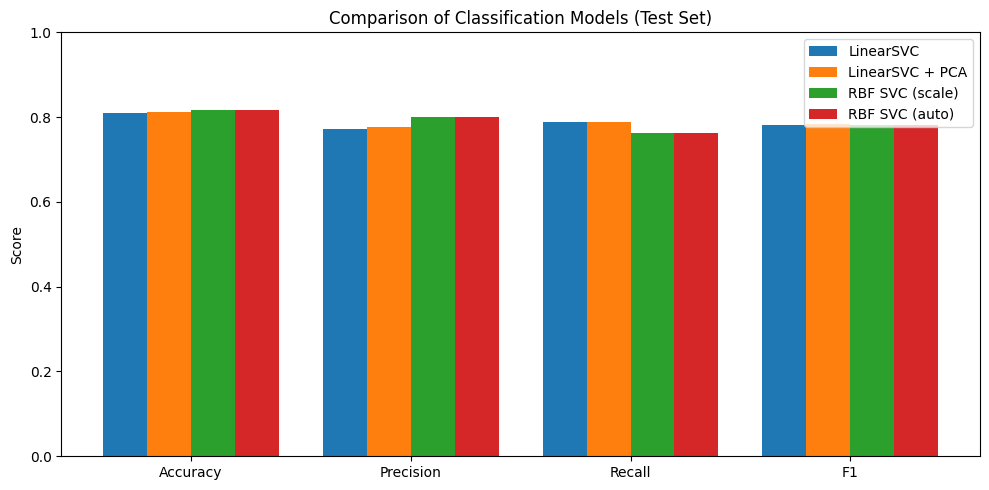

In [ ]:
def compute_metrics(y_true, y_pred):
  return [accuracy_score(y_true, y_pred),precision_score(y_true, y_pred),recall_score(y_true, y_pred),f1_score(y_true, y_pred)]

metrics_linear       = compute_metrics(y_test_targets, y_test_pred)
metrics_linear_pca   = compute_metrics(y_test_targets, y_test_pred_linear)
metrics_rbf_scale    = compute_metrics(y_test_targets, y_test_pred_rbf)
metrics_rbf_auto     = compute_metrics(y_test_targets, y_test_pred_rbf_auto)


model_names = [
    "LinearSVC",
    "LinearSVC + PCA",
    "RBF SVC (scale)",
    "RBF SVC (auto)"
]

metric_names = ["Accuracy", "Precision", "Recall", "F1"]

values = np.array([
    metrics_linear,
    metrics_linear_pca,
    metrics_rbf_scale,
    metrics_rbf_auto
])

x = np.arange(len(metric_names))
width = 0.2

plt.figure(figsize=(10,5))

for i in range(len(model_names)):
    plt.bar(x + i*width, values[i], width, label=model_names[i])

plt.xticks(x + width*1.5, metric_names)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparison of Classification Models (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

# Task -9 Gaussian Naive Bayes

The metrics using this method instead of SVM are less accurate, accuracy,precision, F1-score are smaller than the ones from SVM, but the Recall which is the most important is higher here in the test set: 0.84. Nevertheless, the Recall in training set which is 1, is very conserning because the False Negative there was zero, which mean that the machine is perfect to predicting the actual disasters as disaster, but the most possible scenario is again the overffiting to the data.

In [ ]:
#Bayes classifier
gnb = GaussianNB()
# Fit gaussian
gnb.fit(X_train_dense,  y_train_targets)
# Predict
y_train_pred_gnb = gnb.predict(X_train_dense)
y_test_pred_gnb  = gnb.predict(X_test_dense)

evaluate(y_train_targets, y_train_pred_gnb, "Gaussian Naive Bayes - Train")
evaluate(y_test_targets,  y_test_pred_gnb,  "Gaussian Naive Bayes - Test")

Gaussian Naive Bayes - Train Metrics:
Accuracy : 0.8663
Precision: 0.7627
Recall   : 1.0000
F1-score : 0.8654


Gaussian Naive Bayes - Test Metrics:
Accuracy : 0.6391
Precision: 0.5518
Recall   : 0.8471
F1-score : 0.6683


